<a href="https://colab.research.google.com/github/Josepholaidepetro/Flower-species/blob/main/notebook/AIsat_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 18.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 59 kB 7.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-py3-none-any.whl size=73268 sha256=a856d77b9c2a4507c81c0c3c2b8b6d7c686455a4875851a3ebef0ba5b4b86f73
  Stored in directory: /root/.cache/pip/wheels/1c/dd/dd/c493e6f981182c1411e288c553310f76e212bac3afbdac1294
Successfully built kaggle


In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
!mkdir -p /content/files

In [ ]:
%cd /content/files

/content/files


In [ ]:

# Download dataset from kaggle
!kaggle competitions download -c ai6-dl-cohort-6-challenge

 94% 280M/297M [00:01<00:00, 228MB/s]
100% 297M/297M [00:01<00:00, 247MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: flower_data/train/37/image_03816.jpg  
  inflating: flower_data/train/37/image_03817.jpg  
  inflating: flower_data/train/37/image_03818.jpg  
  inflating: flower_data/train/37/image_03819.jpg  
  inflating: flower_data/train/37/image_03823.jpg  
  inflating: flower_data/train/37/image_03824.jpg  
  inflating: flower_data/train/37/image_03825.jpg  
  inflating: flower_data/train/37/image_03826.jpg  
  inflating: flower_data/train/37/image_03827.jpg  
  inflating: flower_data/train/37/image_07285.jpg  
  inflating: flower_data/train/37/image_07286.jpg  
  inflating: flower_data/train/37/image_07287.jpg  
  inflating: flower_data/train/37/image_07288.jpg  
  inflating: flower_data/train/37/image_07289.jpg  
  inflating: flower_data/train/37/image_07290.jpg  
  inflating: flower_data/train/37/image_07291.jpg  
  inflating: flower_data/train/37/image_07292.jpg  
  inflating: flower_data/train/37/image_07293.jpg  
  inflating: 

In [ ]:
import os, sys, gc
import numpy as np
import pandas as pd
import random
import copy
from tqdm import tqdm
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import *

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from random import shuffle 
from shutil import copyfile
%matplotlib inline

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(21)

In [ ]:
# Check if pytorch is imported and if GPU is enabled
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.15
# specify data directory
train = "/content/files/flower_data/train"

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

# choose the training datasets
train_data = datasets.ImageFolder(train, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
    sampler=valid_sampler, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


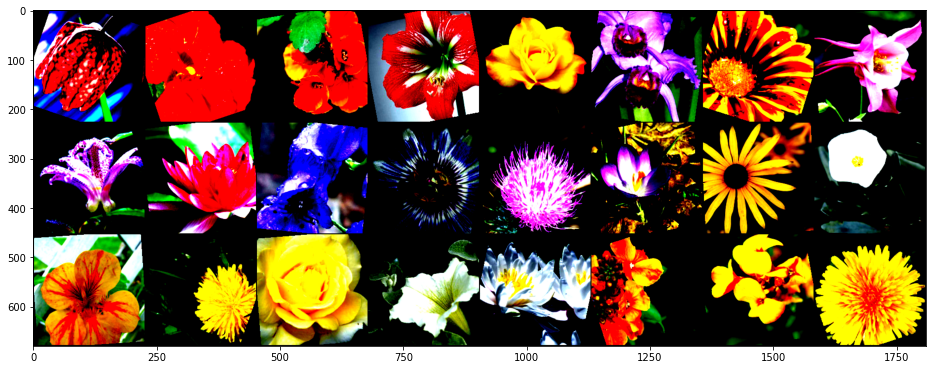

In [ ]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), "models/"+f"bestmodel.pt")
        self.val_loss_min = val_loss

In [ ]:
import json

with open('/content/files/flower_data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [ ]:
# Load a pretrained model
model = models.resnet18(pretrained=False)
model.fc # Check resnet's fully connected layer

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model = models.resnet18(pretrained=True)
# Freeze parameters so we don't backprop through them
# for param in model.parameters():
#     param.requires_grad = False
    
# Get model Output Size = Number of Categories
output_size = len(cat_to_name)

# Input size from current classifier
input_size = model.fc.in_features

classifier = nn.Sequential(nn.Linear(input_size, output_size)
                          )

model.fc = classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.25, verbose=True)
early_stopping = EarlyStopping(patience=6, verbose=True)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
directory = 'models/'
epochs = 2
train_loss_list, valid_loss_list = [], []
valid_acc_list = []

for epoch in range(epochs):
    if not os.path.exists(directory):
        os.makedirs(directory)

    #### TRAIN
    model.train()
    train_loss = 0
    train_counter = 0
    for bi, (samples, labels) in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        train_counter += 1
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
      
    train_loss = train_loss/train_counter
    train_loss_list.append(train_loss)

    #### VALID
    valid_loss = 0
    with torch.no_grad():
        model.eval()
        total_label, correct = 0, 0
        samples, labels = iter(valid_loader).next()
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)
        loss = criterion(output, labels)
        valid_loss = loss.item()
        pred = torch.argmax(output, dim=1)
        total_label = labels.size(0)
        correct = pred.eq(labels).sum().item()

    valid_acc = (100 * correct) // total_label
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    print('[Epoch {}/{}] -> Train Loss: {:.4f} -> Valid Loss: {:.4f}, Valid Accuracy: {:.3f}%'.format(epoch+1, epochs, train_loss, valid_loss, valid_acc))

    # Early Stopping
    early_stopping(valid_loss, model)  
    if early_stopping.early_stop:
        print("Early stopping at {} epoch".format(epoch))
        break

    scheduler.step(valid_loss)

  0%|          | 0/102 [00:00<?, ?it/s]

[Epoch 1/2] -> Train Loss: 2.6980 -> Valid Loss: 1.2195, Valid Accuracy: 84.000%
Validation loss decreased (inf --> 1.219503).  Saving model ...


 86%|████████▋ | 88/102 [01:22<00:13,  1.07it/s]


[Epoch 2/2] -> Train Loss: 0.9131 -> Valid Loss: 0.6414, Valid Accuracy: 92.000%
Validation loss decreased (1.219503 --> 0.641439).  Saving model ...


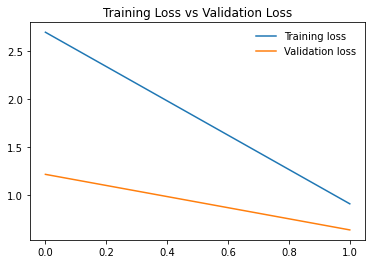

In [ ]:
plt.plot(train_loss_list, label = 'Training loss')
plt.plot(valid_loss_list, label = 'Validation loss')
plt.legend(frameon = False)
plt.title('Training Loss vs Validation Loss')
plt.show()

In [ ]:
def load_checkpoint(model, file="models/"+f"bestmodel.pt"):
    state_dict = torch.load(file)
    model.load_state_dict(state_dict)
    # model.load_state_dict(state_dict, strict=False)
    return model

chkp_model = load_checkpoint(model)
chkp_model = chkp_model.to(device)

In [ ]:
with torch.no_grad():
    valid_loss = 0.0
    chkp_model.eval()
    total_label, correct = 0, 0
    for samples, labels in valid_loader:
        samples, labels = samples.to(device), labels.to(device)
        output = chkp_model(samples)
        loss = criterion(output, labels)
        valid_loss += loss.item()*samples.size(0)
        _, predicted = torch.max(output.data, 1)
        total_label += labels.size(0)
        correct += (predicted == labels).sum().item()

    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_acc = (100 * correct) // total_label

print('Valid Loss: {:.4f}, Valid Accuracy: {:.3f}%'.format(valid_loss, valid_acc))

Valid Loss: 0.0863, Valid Accuracy: 91.000%


In [ ]:
class_to_idx = train_data.class_to_idx
idx_to_class = {class_to_idx[k]: k for k in class_to_idx}

In [ ]:
idx_to_class

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

In [ ]:
class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

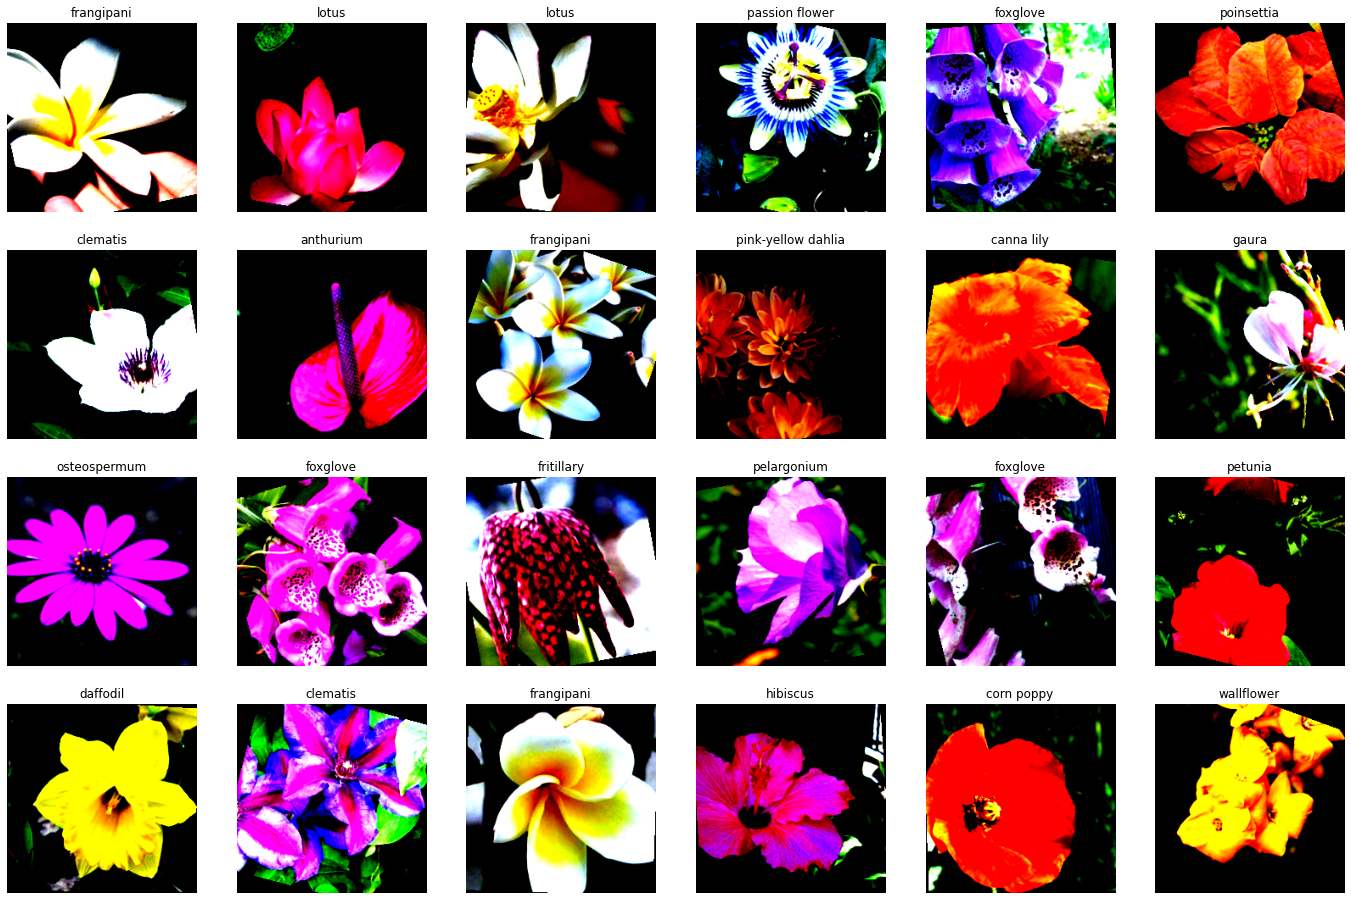

In [ ]:
samples, _ = iter(valid_loader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = chkp_model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(cat_to_name[idx_to_class[pred[num]]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

In [ ]:
class loadTest(Dataset):
    def __init__(self, dir, df, file_class, transform = None):
        self.file_list = [x for x in df[file_class]]
        self.dir = dir
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [ ]:
test_dir = "flower_data/test"
df_test = pd.read_csv('flower_data/Sample_Sub.csv')
test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

testset = loadTest(test_dir, df_test, "id", transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False)

In [ ]:
chkp_model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = chkp_model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n for n in fn]
        pred_list += [idx_to_class[p.item()] for p in pred]

submission = pd.DataFrame({"id":fn_list, "class":pred_list})
submission.to_csv('submission.csv', index=False)